In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from torch import nn
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def norm_pose(pose):
    x = (pose[0] + 8) / (8 + 8)
    y = (pose[1] + 8) / (8 + 8)

    return [x, y]

def unnorm_pose(pose):
    x = pose[0] * (8 + 8) - 8
    y = pose[1] * (8 + 8) - 8

    return [x, y]

In [3]:
with open("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/data/shapes_random_samples_100.pkl", 'rb') as f:
    pose_samples, img_samples = pickle.load(f)
        
with open('/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/data/fep_data_out.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
sample_idx = [x[0] for x in data]
start_pose = [x[1] for x in data]
goal_pose = [x[2] for x in data]
end_pose = [x[3] for x in data]
end_dist = [x[4] for x in data]
mu_hist = [x[5] for x in data]
a_hist = [x[6] for x in data]

In [40]:
a_hist_unnorm = []

for a_path in a_hist:
    a_path_unnorm = []
    for a in a_path:
        a_path_unnorm.append(unnorm_pose(a))
    a_hist_unnorm.append(a_path_unnorm)

In [41]:
a_error_hist = []

for i, a_path in enumerate(a_hist_unnorm):
    goal = goal_pose[i]
    a_path_distance_hist = []
    for j, a in enumerate(a_path):
        a_path_distance_hist.append(np.sqrt((a[0] - goal[0])**2 + (a[1] - goal[1])**2))
    a_error_hist.append(a_path_distance_hist)

In [42]:
a_error_hist_np = np.array(a_error_hist)

a_error_hist_np

array([[ 5.3310653 ,  5.05125839,  5.5863928 , ...,  0.31420427,
         0.39204565,  0.18593375],
       [11.93542435, 11.96876449, 11.996491  , ...,  6.96897972,
         6.92037766,  6.84229516],
       [ 4.49444981,  4.46853413,  4.39624464, ...,  0.53902876,
         0.39021917,  0.22070358],
       ...,
       [ 8.33077336,  8.29275238,  8.04718705, ...,  3.10561021,
         3.12091389,  3.00763999],
       [10.57405783, 10.0023714 ,  9.67519778, ...,  0.39188337,
         0.29926995,  0.16511241],
       [ 4.7655848 ,  4.28841975,  3.87171871, ...,  0.2231228 ,
         0.19083873,  0.19117147]])

In [43]:
avg_4 = np.mean(a_error_hist_np, 0)
std_4 = np.std(a_error_hist_np, 0)

In [ ]:
# avg_8 = np.mean(a_error_hist_np, 0)
# std_8 = np.std(a_error_hist_np, 0)

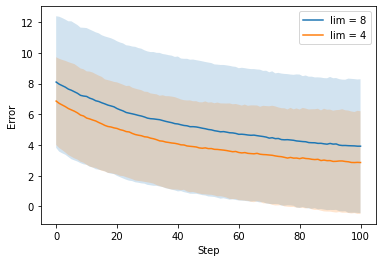

In [46]:
lower_4 = avg_4 - std_4
upper_4 = avg_4 + std_4
lower_8 = avg_8 - std_8
upper_8 = avg_8 + std_8

plt.figure(figsize=(6,4))
plt.xlabel('Step')
plt.ylabel('Error')
plt.plot(avg_8, label='lim = 8')
plt.fill_between(range(101), lower_8, upper_8, alpha=0.2)
plt.plot(avg_4, label='lim = 4')
plt.fill_between(range(101), lower_4, upper_4, alpha=0.2)

plt.legend()
plt.show()

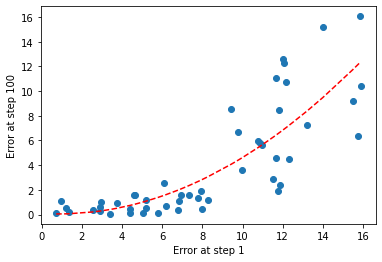

In [10]:
start_pose_x = [x[0] for x in start_pose]
start_pose_y = [x[1] for x in start_pose]

goal_pose_x = [x[0] for x in goal_pose]
goal_pose_y = [x[1] for x in goal_pose]

real_dist = []

for i in range(len(start_pose_x)):
    real_dist.append(np.sqrt((start_pose_x[i] - goal_pose_x[i])**2 + (start_pose_y[i] - goal_pose_y[i])**2))

dist_histories = []

for i in range(len(real_dist)):
    dist_histories.append([real_dist[i], end_dist[i]])

ls_sorted = sorted(dist_histories, key=lambda x: x[0])
ls_sorted = np.array(ls_sorted)

plt.figure(figsize=(6,4))
plt.xlabel('Error at step 1')
plt.ylabel('Error at step 100')
plt.scatter(ls_sorted[:, 0], ls_sorted[:, 1])

z = np.polyfit(ls_sorted[:, 0], ls_sorted[:, 1], 2)
p = np.poly1d(z)
plt.plot(ls_sorted[:, 0],p(ls_sorted[:, 0]),"r--")
plt.show()

In [5]:
class Fire(nn.Module):
    def __init__(self, inplanes: int, squeeze_planes: int, expand1x1_planes: int, expand3x3_planes: int) -> None:
        super().__init__()
        self.inplanes = inplanes
        
        self.squeeze = nn.Sequential(
            nn.Conv2d(inplanes, squeeze_planes, kernel_size=1),
            nn.BatchNorm2d(squeeze_planes),
            nn.LeakyReLU(inplace=True)
        )

        self.expand1x1 = nn.Sequential(
            nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1),
            nn.BatchNorm2d(expand1x1_planes),
            nn.LeakyReLU(inplace=True)
        )

        self.expand3x3 = nn.Sequential(
            nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1),
            nn.BatchNorm2d(expand3x3_planes),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.squeeze(x)
        return torch.cat(
            [self.expand1x1(x), self.expand3x3(x)], 1
        )

class SqueezePoseNetEncoder(nn.Module):

    def __init__(self, dropout=0.5):
        super(SqueezePoseNetEncoder, self).__init__()
    
        self.squeeze = nn.Sequential(
            # conv1
            nn.Conv2d(1, 96, kernel_size=7, stride=2),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(inplace=True),
            # pool1
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            # fire2 & concat
            Fire(96, 16, 64, 64),
            # fire3 & concat
            Fire(128, 16, 64, 64),
            # fire4 & concat
            Fire(128, 32, 128, 128),
            # pool4
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            # frie5 & concat
            Fire(256, 32, 128, 128),
            # fire6 & concat
            Fire(256, 48, 192, 192),
            # fire7 & concat
            Fire(384, 48, 192, 192),
            # fire8 & concat
            Fire(384, 64, 256, 256),
            # pool8
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            # fire9 & concat
            Fire(512, 64, 256, 256),
            # drop9
            nn.Dropout(p=dropout), 
            # conv_final
            nn.Conv2d(512, 1000, kernel_size=1),
            nn.BatchNorm2d(1000),
            nn.LeakyReLU(inplace=True), 
            # pool10
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.pose = nn.Sequential(
            # fc11
            nn.Linear(1000, 500),
            nn.LeakyReLU(),
            # position x
            nn.Linear(500, 2),
            nn.LeakyReLU()
        )

    def forward(self, x):

        x = self.squeeze(x)
        x = x.view(-1, 1, 1000)
        x = self.pose(x)

        return x

In [17]:
with open("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/data/shapes_fixed_mono8_2_10k_norm_np.pkl", 'rb') as f:
    pose, img = pickle.load(f)

# data preperation
batch_size = 30
train_test_ratio = 0.7

ratio_id = int(pose.shape[0] * train_test_ratio)

test_pose = pose[ratio_id:]
test_img = img[ratio_id:]

test_set = TensorDataset(torch.from_numpy(test_pose).float(), torch.from_numpy(test_img).float())
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

net = SqueezePoseNetEncoder()
net.eval()
net.load_state_dict(torch.load("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/SPN_Enc_3_100e.pt", map_location='cpu'))

<All keys matched successfully>

In [18]:
def unnorm_pose(pose):
    return [pose[0] * 18 - 9, pose[1] * 18 - 9]

In [19]:
ls_true = []
ls_pred = []
ls_error = []

for pose, img in test_loader:
    true = [pose[:, 0].item(), pose[:, 1].item()]
    pred = net(img.unsqueeze(1)).detach().squeeze().numpy()

    error = [unnorm_pose(true)[0] - unnorm_pose(pred)[0], unnorm_pose(true)[1] - unnorm_pose(pred)[1]]

    ls_true.append(unnorm_pose(true))
    ls_pred.append(unnorm_pose(pred))
    ls_error.append(error)

true = np.array(ls_true)
pred = np.array(ls_pred)
error = np.array(ls_error)

error_dist = np.sqrt(error[:, 0] ** 2 + error[:, 1] ** 2)

In [20]:
print(np.mean(error[:, 0]), np.mean(error[:, 1]))

-0.28690801190112913 0.0016346379475071443


In [22]:
print(np.mean(error_dist))

1.257815699690419


In [21]:
%matplotlib

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(pose[:, 0], pose[:, 1], error_dist)

ax.scatter(true[:, 0], true[:, 1], error_dist)
# ax.scatter(true[:, 0], true[:, 1], s=3)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('error')

Using matplotlib backend: Qt5Agg


Text(0.5, 0, 'error')